In [1]:
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
import os
import numpy as np
import time

print(tf.__version__)
print(os.getcwd())

2.4.1
C:\Users\mark.fowler\OneDrive - LSTM\LSTM\Machine Learning\PPF Ovaries\London School data\Class - Fertility


In [18]:
#benchmark build and load

t0 = time.time()


InputShape = (224, 224, 1)

layers = [
    #input ('input_shap') hidden layer
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",activation=tf.nn.relu, input_shape=InputShape),
    #pooling layer - 2,2 strides halves input for pool
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    #2nd hidden layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same",activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    
    #3rd hidden layer
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same",activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    #4th hidden layer
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same",activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    tf.keras.layers.Flatten(),
    #output layer - 2 nodes (normal / affected)
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
]


model = tf.keras.Sequential(layers)
model.compile(optimizer = tf.optimizers.RMSprop(),
             loss=tf.losses.SparseCategoricalCrossentropy(),
             metrics=[tf.metrics.BinaryAccuracy()])


##use the open cv library for function load these images as a pixel array
import cv2
def load_image(file_path):
    return cv2.imread(file_path)

##function to extract label of image from file name
def extract_label(file_name):
    return 1 if "fer" in file_name else 0

#prep data function
def res_prep(img, side = 224):
    #min_side = min(img.shape[0], img.shape[1]) #crop to smallests side if needed
    #img = img[:min_side, :min_side] #crop no2
    img = cv2.resize(img, (side,side)) #resize to "side" piuxel length - tweak
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # greyscale
    return img / 2555.0

test = []
test_path = "./Test/"  #use working directory + ./Train/ as train_path
image_files_test = os.listdir(test_path)
test_labels = [extract_label(file) for file in image_files_test]
test_images = []
for file in image_files_test:
    img = load_image(test_path + file)
    test_images.append(img)
for i in range(len(test_labels)):
    test.append(res_prep(test_images[i]))
test = np.array(test)



#create new model with saved weights
test_model = tf.keras.Sequential(layers)
test_model.load_weights("model_no_aug.tf")
#get prediction probabilities (inc. code to expand dimensions to fit into algorithm)
test_predictions = test_model.predict(np.expand_dims(test, axis = -1))


 

#measure accuracy using scikitlearn's confusion matrix
pred = []
for i in range(len(test_predictions)):
    pred.append(np.argmax(test_predictions[i]))

    
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("conf matrix", confusion_matrix(test_labels, pred))
print()
print("Report",classification_report(test_labels, pred))
print()
print(round(accuracy_score(test_labels, pred),3))


t1 = time.time()
total = t1-t0
print('Time:',round(total,1),'seconds')

conf matrix [[77  4]
 [31 45]]

Report               precision    recall  f1-score   support

           0       0.71      0.95      0.81        81
           1       0.92      0.59      0.72        76

    accuracy                           0.78       157
   macro avg       0.82      0.77      0.77       157
weighted avg       0.81      0.78      0.77       157


0.777
Time: 28.3 seconds


In [9]:
#transfer learning build and load

t0 = time.time()


##use the open cv library for function load these images as a pixel array
import cv2
def load_image(file_path):
    return cv2.imread(file_path)

##function to extract label of image from file name
def extract_label(file_name):
    return 1 if "fer" in file_name else 0

#prep data function
def res_prep(img, side = 224):
    img = cv2.resize(img, (side,side)) 
    return img 


Res50_test = []
test_path = "./Test/"  #use working directory + ./Train/ as train_path
image_files_test = os.listdir(test_path)
test_labels = [extract_label(file) for file in image_files_test]
test_images = []
for file in image_files_test:
    img = load_image(test_path + file)
    test_images.append(img)
for i in range(len(test_labels)):
    Res50_test.append(res_prep(test_images[i]))
Res50_test = np.array(Res50_test)



# add preprocessing layer to the front of model
IMAGE_SIZE = [224, 224]
ResNet50 = applications.ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in ResNet50.layers:
  layer.trainable = False

#specify output layer
x = Flatten()(ResNet50.layers[-1].output)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=ResNet50.input, outputs=prediction)

# view the structure of the model
#model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(),
  optimizer='adam',
  metrics=['BinaryAccuracy']
)



test_model = Model(inputs=model.input, outputs=prediction)
test_model.load_weights("Res50_model_32.tf")

#get prediction probabilities (inc. code to expand dimensions to fit into algorithm)
test_imgs = np.array(Res50_test)
test_predictions = test_model.predict(test_imgs)

 

#measure accuracy using scikitlearn's confusion matrix
pred = []
for i in range(len(test_predictions)):
    pred.append(np.argmax(test_predictions[i]))

    
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("conf matrix", confusion_matrix(test_labels, pred))
print()
print("Report",classification_report(test_labels, pred))
print()
print(round(accuracy_score(test_labels, pred),3))


t1 = time.time()
total = t1-t0
print('Time:',round(total,1),'seconds')

conf matrix [[77  4]
 [ 5 71]]

Report               precision    recall  f1-score   support

           0       0.94      0.95      0.94        81
           1       0.95      0.93      0.94        76

    accuracy                           0.94       157
   macro avg       0.94      0.94      0.94       157
weighted avg       0.94      0.94      0.94       157


0.943
Time: 38.3 seconds


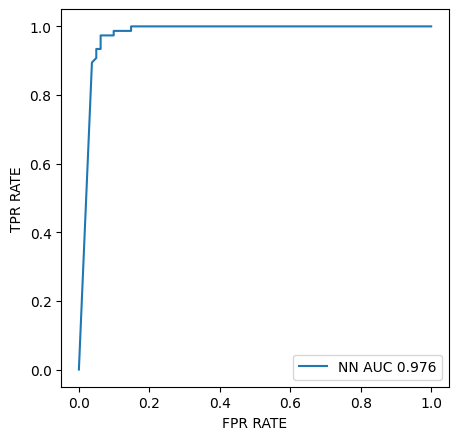

In [10]:
from sklearn import metrics
from matplotlib import pyplot as plt
# ROC curve: common with binary classifiers - comp of true positive against false positive
# true negatives (FPR) = specificity / true positives (TPR) = sensitivity
# AUC = Area Under the Curve

#nn
nn_pred = test_predictions[0:157, 1] 
nn_fpr, nn_tpr, nn_thresholds = metrics.roc_curve(test_labels, nn_pred, pos_label=1)
nn_auc = metrics.auc(nn_fpr, nn_tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(nn_fpr, nn_tpr, linestyle='-', label='NN AUC %0.3f' % nn_auc)
plt.xlabel('FPR RATE')
plt.ylabel('TPR RATE')
plt.legend()
plt.show()

In [4]:
#investigate predictions
for i in range(len(test_predictions)):
    print(i, end='\t')
    print(image_files_test[i], end='\t')
    print(np.argmax(test_predictions[i]))

0	fer (100).jpg	1
1	fer (101).jpg	1
2	fer (15).jpg	0
3	fer (18).jpg	1
4	fer (2).jpg	1
5	fer (20).jpg	1
6	fer (24).jpg	1
7	fer (33).jpg	0
8	fer (34).jpg	1
9	fer (35).jpg	0
10	fer (40).jpg	1
11	fer (44).jpg	1
12	fer (45).jpg	0
13	fer (53).jpg	1
14	fer (54).jpg	1
15	fer (57).jpg	1
16	fer (58).jpg	1
17	fer (62).jpg	1
18	fer (65).jpg	1
19	fer (66).jpg	1
20	fer (70).jpg	1
21	fer (74).jpg	1
22	fer (75).jpg	1
23	fer (8).jpg	1
24	fer (81).jpg	1
25	fer (84).jpg	1
26	fer (88).jpg	1
27	fer (90).jpg	1
28	fer (92).jpg	1
29	fer (94).jpg	1
30	fer (99).jpg	1
31	fer c2 (10).JPG	1
32	fer c2 (11).JPG	1
33	fer c2 (13).JPG	1
34	fer c2 (15).JPG	1
35	fer c2 (19).JPG	1
36	fer c2 (21).JPG	1
37	fer c2 (22).JPG	1
38	fer c2 (23).JPG	1
39	fer c2 (25).JPG	0
40	fer c2 (27).JPG	1
41	fer c2 (28).JPG	1
42	fer c2 (30).JPG	1
43	fer c2 (31).JPG	1
44	fer c2 (38).JPG	1
45	fer c2 (40).JPG	1
46	fer c2 (42).JPG	1
47	fer c2 (43).JPG	1
48	fer c2 (8).JPG	1
49	fer n2 (11).jpg	1
50	fer n2 (19).jpg	1
51	fer n2 (2).jpg	1
52	fer n2 (20

In [3]:
#HILARY DATA TEST

t0 = time.time()


##use the open cv library for function load these images as a pixel array
import cv2
def load_image(file_path):
    return cv2.imread(file_path)

##function to extract label of image from file name
def extract_label(file_name):
    return 1 if "normal" in file_name else 0

#prep data function
def res_prep(img, side = 224):
    img = cv2.resize(img, (side,side)) 
    return img 

Res50_test = []
test_path = "C:\\Users\mark.fowler\OneDrive - LSTM\LSTM\Machine Learning\PPF Ovaries\Archive\hilary images/"  #use working directory + ./Train/ as train_path
image_files_test = os.listdir(test_path)
test_labels = [extract_label(file) for file in image_files_test]
test_images = []
for file in image_files_test:
    img = load_image(test_path + file)
    test_images.append(img)
for i in range(len(test_labels)):
    Res50_test.append(res_prep(test_images[i]))
Res50_test = np.array(Res50_test)





# add preprocessing layer to the front of model
IMAGE_SIZE = [224, 224]
ResNet50 = applications.ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in ResNet50.layers:
  layer.trainable = False

#specify output layer
x = Flatten()(ResNet50.layers[-1].output)
prediction = Dense(2, activation='softmax')(x)

# create a model object
model = Model(inputs=ResNet50.input, outputs=prediction)

# view the structure of the model
#model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss=tf.losses.SparseCategoricalCrossentropy(),
  optimizer='adam',
  metrics=['BinaryAccuracy']
)



test_model = Model(inputs=model.input, outputs=prediction)
test_model.load_weights("Res50_model_32.tf")

#get prediction probabilities (inc. code to expand dimensions to fit into algorithm)
test_imgs = np.array(Res50_test)
test_predictions = test_model.predict(test_imgs)

 

#measure accuracy using scikitlearn's confusion matrix
pred = []
for i in range(len(test_predictions)):
    pred.append(np.argmax(test_predictions[i]))

    
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("conf matrix", confusion_matrix(test_labels, pred))
print()
print("Report",classification_report(test_labels, pred))
print()
print(round(accuracy_score(test_labels, pred),3))


t1 = time.time()
total = t1-t0
print('Time:',round(total,1),'seconds')

conf matrix [[22 38]
 [ 0  3]]

Report               precision    recall  f1-score   support

           0       1.00      0.37      0.54        60
           1       0.07      1.00      0.14         3

    accuracy                           0.40        63
   macro avg       0.54      0.68      0.34        63
weighted avg       0.96      0.40      0.52        63


0.397
Time: 160.6 seconds
